First we need to add "LinearAlgebra", "Plots" and "SparseArrays" packages.

In [1]:
using LinearAlgebra
using Plots
using SparseArrays

We can define functions for drawing Ellipses and Circles (We use parametric equations for this purpose).

In [2]:
function EllipseShape(z, a, b, alpha)
    phi = LinRange(0, 2*pi, 500)
    R = [cos(alpha) -sin(alpha); sin(alpha) cos(alpha)]
    t = zeros(Float64, (2, 500))
    for j = 1:500
        t[:, j] = z + R*[a*cos(phi[j]); b*sin(phi[j])] 
    end
    return t
end

function CircleShape(z, r)
    return EllipseShape(z, r, r, 0)
end

CircleShape (generic function with 1 method)

For non-linear least-squares problems, we use gauss-newton method.So it convenient to define a gauss-newton solver function.

In [3]:
MAX_ITERATION = 1000
EPSILON = 1e-6

1.0e-6

In [4]:
function gauss_newton(J, f, u0)
    u = u0
    h = - J(u)\ f(u)
    u = u + h
    for q = 2:MAX_ITERATION
        h = - J(u)\ f(u)
        u = u + h
        if norm(h) < EPSILON
#             println("LOG:itration = "*string(q)) # We can Log itration of method
            break
        end
    end
    return u
end

gauss_newton (generic function with 1 method)

Now we can solve circle fitting problem in both algebraic and geometric ways.
Data points:

In [5]:
data1 = [1 2 5 7 9 3; 7 6 8 7 5 7]

2×6 Array{Int64,2}:
 1  2  5  7  9  3
 7  6  8  7  5  7

First we find the algebraic answer(according to paper).

In [6]:
function make_B(data)
    m = size(data)[2]
    B = zeros(Float64, (m, 4))
    for i = 1:m
        x = data[:, i]
        B[i, :] = [norm(x)^2 x[1] x[2] 1]
    end
    
    return B
end

function circle_alg(data)
    B = make_B(data)
    v = svd(B).V[:, 4]    #Smallest right singular vector of B
    a = v[1]
    b = v[2:3]
    c = v[4]
    z = [-b[1]/(2*a), -b[2]/(2*a)]
    r = sqrt((norm(b)/(2*a))^2 - c/a)
    return z, r
end

circle_alg (generic function with 1 method)

In [7]:
z_c_alg, r_c_alg = circle_alg(data1)
println("Results of algebraic distance fitting:")
println("z:"*string(z_c_alg))
println("r:"*string(r_c_alg))

Results of algebraic distance fitting:
z:[5.379413317248785, 7.25319847681616]
r:3.0370414582692327


Now we solve geometric distance problem.

In [8]:
function make_c_J_func(data)
    m = size(data)[2]
    J = zeros(Float64, (m, 3))
    function J_func(u)
        for i = 1:m
            x = data[:, i]
            den = norm(u[1:2] - x)
            J[i, 1] = (u[1] - x[1]) / den
            J[i, 2] = (u[2] - x[2]) / den
            J[i, 3] = -1
        end
        return J
    end
    return J_func
end

function make_c_f_func(data)
    m = size(data)[2]
    function f_func(u)
        z = u[1:2]
        r = u[3]
        f = zeros(Float64, m)
        for i = 1:m
            x = data[:, i]
            f[i] = norm(z - x) - r
        end
        return f
    end
    return f_func
end
    
function circle_geo(data)
    u0 = [z_c_alg..., r_c_alg]  # Algebraic Results 
    J = make_c_J_func(data)
    f = make_c_f_func(data)
    u = gauss_newton(J, f, u0)
    return u[1:2], u[3]
end

circle_geo (generic function with 1 method)

In [9]:
z_c_geo, r_c_geo = circle_geo(data1)
println("Results of geometric distance fitting:")
println("z:"*string(z_c_geo))
println("r:"*string(r_c_geo))

Results of geometric distance fitting:
z:[4.739782426565383, 2.9835327746894675]
r:4.714225979682377


We can see results in graph below (Dashed line for algebraic and solid line for geometric).

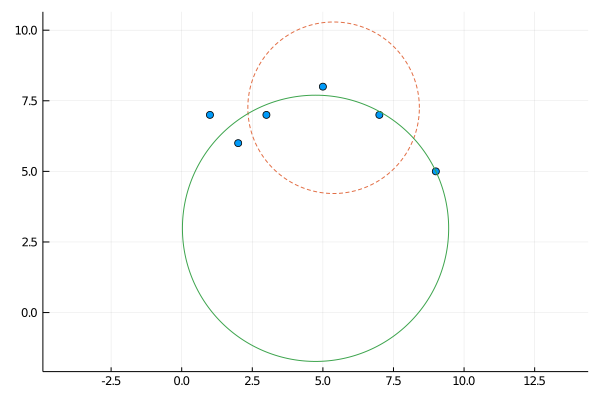

In [10]:
C1 = CircleShape(z_c_alg, r_c_alg)
C2 = CircleShape(z_c_geo, r_c_geo)
scatter([data1[1, :]], [data1[2, :]])
plot!([C1[1, :]], [C1[2, :]], aspect_ratio = 1, legend = false, linestyle = :dash)
plot!([C2[1, :]], [C2[2, :]], aspect_ratio = 1, legend = false, linestyle = :solid)

We can also use parametric equation for geometric fitting.

In [11]:
function make_c_para_J_func(data)
    m = size(data)[2]
    J = zeros(Float64, (2*m, m+3))
    function J_func(u)
        phi = u[1:m]
        z = u[m+1:m+2]
        r = u[m+3]
        
        A = zeros(Float64, (m, 3))
        A[:, 1] = -ones(Float64, m)
        A[:, 2] = zeros(Float64, m)
        A[:, 3] = -cos.(phi)
        
        B = zeros(Float64, (m, 3))
        B[:, 1] = zeros(Float64, m)
        B[:, 2] = -ones(Float64, m)
        B[:, 3] = -sin.(phi)
        
        S = Diagonal(sin.(phi))
        C = Diagonal(cos.(phi))
        
        J = [r.*S A; -r.*C B]  # Julia automaticly converts it to a SparseMatrix
        return J
    end
end

function make_c_para_f_func(data)
    m = size(data)[2]
    function f_func(u)
        phi = u[1:m]
        z = u[m+1:m+2]
        r = u[m+3]
        f = zeros(Float64, 2*m)
        for i = 1:m
            x = z[1] + r*cos(phi[i])
            y = z[2] + r*sin(phi[i])
            f[i] = data[1, i] - x
            f[m+i] = data[2, i] - y
        end
        return f
    end
end

function circle_para(data)
    m = size(data)[2]
    phi0 = [atan((data[2, i] - z_c_alg[2])/(data[1, i] - z_c_alg[1])) for i = 1:m]
    u0 = [phi0..., z_c_alg..., r_c_alg]  # Algebraic Results 
    J = make_c_para_J_func(data)
    f = make_c_para_f_func(data)
    u = gauss_newton(J, f, u0)
    return u[m+1:m+2], u[m+3]
end

circle_para (generic function with 1 method)

In [12]:
z_c_para, r_c_para = circle_para(data1)
println("Results of geometric distance fitting (in parametric form):")
println("z:"*string(z_c_para))
println("r:"*string(r_c_para))

Results of geometric distance fitting (in parametric form):
z:[4.739782448640401, 2.9835328875034417]
r:4.714225892665794


We have same results with previous geometric fitting (Solid line in graph).